In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from gpytorch.kernels import MaternKernel

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

%matplotlib inline

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
torch.random.manual_seed(2021)

F0 = 100 ## init price
V0 = 0.25 ## init price
mu = 0.05 ## rate of return

alpha = 0.15
beta = 1.0
rho = 0.0 ## correlation between vol and forward
gamma = 0.8 ## correlation between two vols

n_task = 3

# T = 2 ## Time of Simulation
steps = 500 ## steps per time
dt = 1 / 252 ## delta t

In [3]:
def cov_mat(n_task, rho, gamma):
    fwd_mat = torch.eye(n_task)
    fwd_vol_mat = torch.eye(n_task) * rho
    vol_mat = torch.ones(n_task, n_task)*gamma + torch.eye(n_task)*(1. - gamma)

    upper = torch.cat((fwd_mat, fwd_vol_mat), -1)
    lower = torch.cat((fwd_vol_mat.t(), vol_mat), -1)
    cov_mat = torch.cat((upper, lower), 0) 
    
    return cov_mat

In [4]:
covar = cov_mat(n_task, rho, gamma)

In [5]:
L = torch.cholesky(covar)

/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  """Entry point for launching an IPython kernel.


In [6]:
DZ = L.matmul(torch.randn(n_task*2, steps) * np.sqrt(dt))

F = torch.zeros(steps, n_task)
V = torch.zeros(steps, n_task)
time = torch.linspace(0, steps * dt, steps)

F[0] = F0
V[0] = V0

for t in range(1, steps):
    F[t] = F[t-1] + V[t-1] * (F[t-1])**beta * DZ[:n_task, t]
    V[t] = V[t-1] + alpha * V[t-1]*DZ[n_task:, t]

In [7]:
n_train = 350

train_x = time[:n_train]
test_x = time[n_train:]

# log_returns = torch.log(F.log()[1:]/F.log()[:-1]) 
log_returns = torch.log(F[1:]) - torch.log(F[:-1])

train_y, test_y = log_returns[:n_train], log_returns[n_train:]

In [8]:
log_returns.std(0)

tensor([0.0204, 0.0204, 0.0201])

Text(0.5, 1.0, 'Vol')

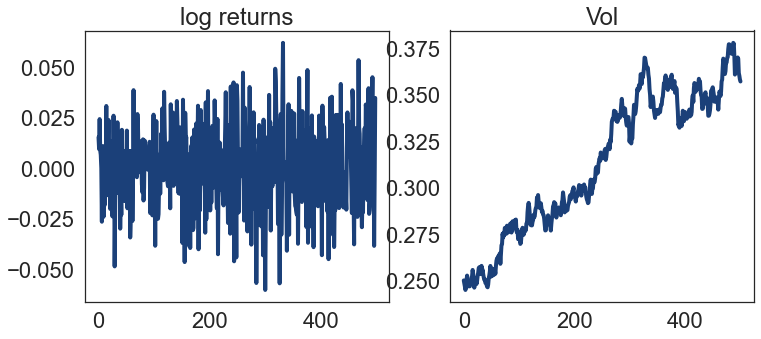

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(log_returns[:,0])
ax[1].plot(V[:,0])
ax[0].set_title("log returns")
ax[1].set_title("Vol")

In [10]:
vec = log_returns#.abs()

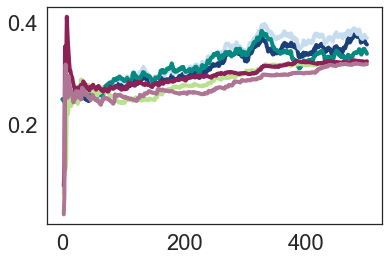

In [11]:
plt.plot(V)
plt.plot(torch.stack([vec[:i].std(0) for i in range(500)]) / dt**0.5)

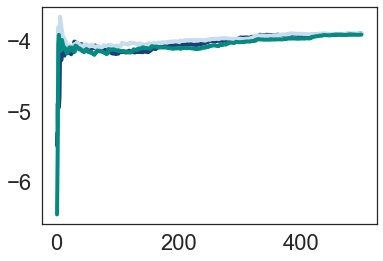

In [12]:
plt.plot(torch.stack([vec[:i].std(0) for i in range(500)]).log())

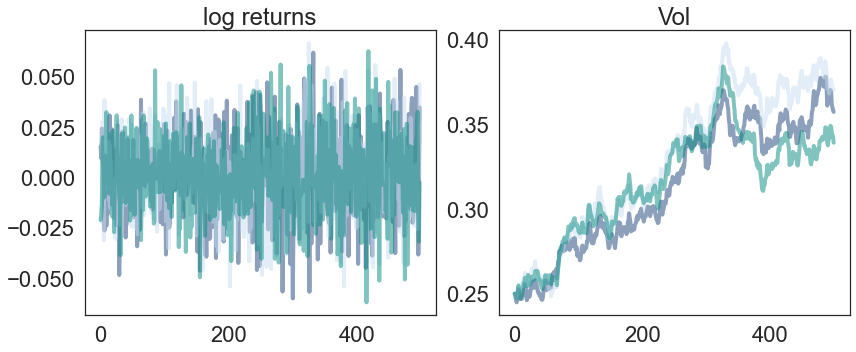

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(log_returns, alpha = 0.5)
ax[1].plot(V, alpha = 0.5)
ax[0].set_title("log returns")
ax[1].set_title("Vol")
plt.tight_layout()

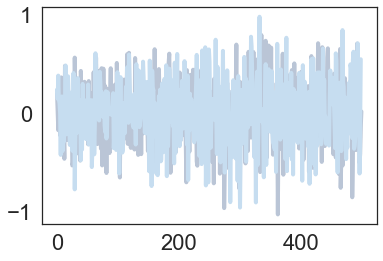

In [14]:
x = torch.randn(log_returns.shape[0]+1) * V[:,0] #* dt**0.5
plt.plot(x, alpha = 0.3)
plt.plot(log_returns[:,0] / dt**0.5)

In [15]:
log_returns.min() / 10

tensor(-0.0062)

In [16]:
log_returns.shape[-1]

3

## Define a new multi-task GP

We're defining an ICM variational GP here.


In [17]:
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel
from voltron.models import MultitaskVariationalGP

Warning no robinhood utils.


In [29]:
from gpytorch.priors import LKJCovariancePrior, SmoothedBoxPrior

prior = LKJCovariancePrior(n_task, eta = 1.0, sd_prior=SmoothedBoxPrior(0.25, 2.0))

model = MultitaskVariationalGP(train_x, n_task, BMKernel(), prior=prior)
model.train()
# [x.constant.data.add_(np.log(V0) + 0.5 * math.log(dt)) for x in model.mean_module.base_means]
# [x.constant for x in model.mean_module.base_means]

MultitaskVariationalGP(
  (index_kernel): IndexKernel(
    (IndexKernelPrior): LKJCovariancePrior()
    (raw_var_constraint): Positive()
  )
  (data_kernel): BMKernel(
    (raw_vol_constraint): Interval(0.000E+00, 1.000E+00)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0): ConstantMean()
      (1): ConstantMean()
      (2): ConstantMean()
    )
  )
)

In [30]:
likelihood = VolatilityGaussianLikelihood(batch_shape = torch.Size((3,)), param="exp", K = 1)

Using gp-exp parameterization.


In [31]:
0.5 * math.log(dt)

-2.7647145437557117

In [32]:
%pdb

Automatic pdb calling has been turned ON


In [33]:
model.initialize_variational_parameters(likelihood, x=train_x, f=None, y=train_y)

Testing output shapes.

In [34]:
from gpytorch.mlls import VariationalELBO

In [35]:
print(list(likelihood.named_parameters()))

[]


In [36]:
mll = VariationalELBO(model = model, likelihood = likelihood, num_data = train_x.shape[0])

In [37]:
%pdb

Automatic pdb calling has been turned OFF


In [38]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 250


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)

In [39]:
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.num_gauss_hermite_locs(25), gpytorch.settings.max_cholesky_size(5000):       
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if i % 50 == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            plt.show()
        optimizer.step()

Iter 1/250 - Loss: -2.001
Iter 51/250 - Loss: -7.338
Iter 101/250 - Loss: -7.453
Iter 151/250 - Loss: -7.252
Iter 201/250 - Loss: -7.476


In [40]:
model.eval();
likelihood.eval();
predictive = model(time)

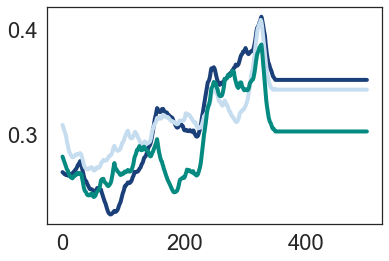

In [41]:
plt.plot(predictive.mean.detach().exp() / dt ** 0.5)

In [42]:
[x.constant for x in model.mean_module.base_means]

[Parameter containing:
 tensor([-4.0952], requires_grad=True),
 Parameter containing:
 tensor([-3.9382], requires_grad=True),
 Parameter containing:
 tensor([-4.0408], requires_grad=True)]

In [43]:
with gpytorch.settings.num_gauss_hermite_locs(25):
    pred_sample_scale = likelihood(predictive).scale.detach() / dt**0.5
    pred_scale = pred_sample_scale.mean(0).detach()

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


In [44]:
dt

0.003968253968253968

In [45]:
pred_scale.shape

torch.Size([500, 3])

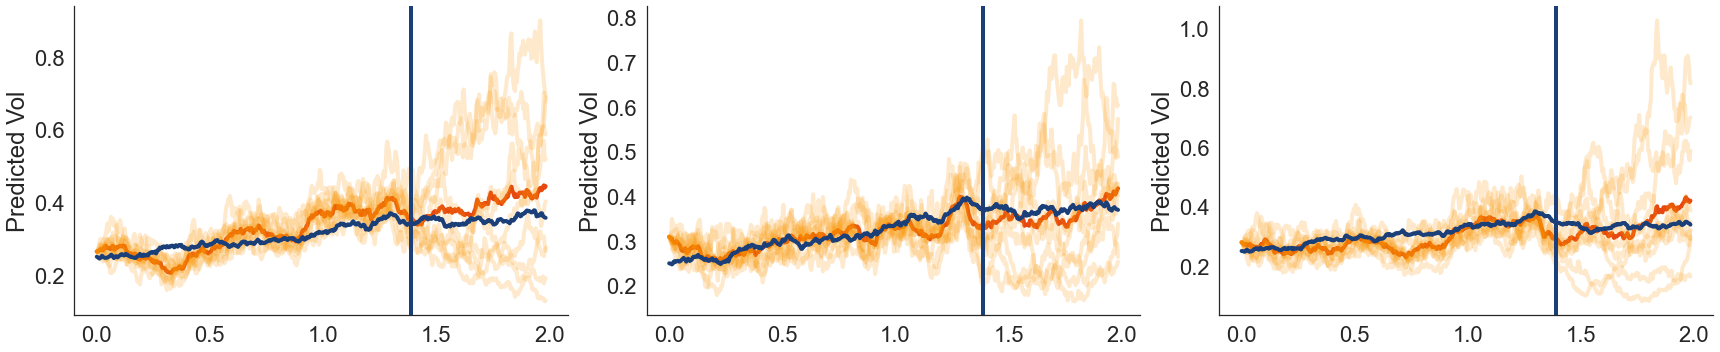

In [46]:
fig, ax = plt.subplots(1, 3, figsize = (24, 5))
plt.subplots_adjust(wspace=0.25)
# ax = ax.reshape(-1)

for i in range(n_task):

    ax[i].plot(time, pred_scale[:, i], color = palette[-2], label = "Posterior Mean")
    ax[i].plot(time, pred_sample_scale[0, :, i], color = palette[-1], alpha = 0.2, label = "Posterior Samples")
    ax[i].plot(time, pred_sample_scale[1:, :, i].t(), color = palette[-1], alpha = 0.2)
    # ax2 = ax[i].twinx()
    # ax2.plot(time, V[:, i], label = "Actual", color='orangered')
    ax[i].plot(time, V[:, i], label = "Actual", color = palette[0])

    ax[i].set_ylabel("Predicted Vol")
    ax[i].axvline(x=train_x[-1])
    # ax2.set_ylabel("Actual Vol")

    # fig.legend()
    
    sns.despine()
    
    # ax[i].set_ylim((0, 3.0))
plt.tight_layout()

In [64]:
model_learned_covar = model.index_kernel.covar_matrix.evaluate().detach()

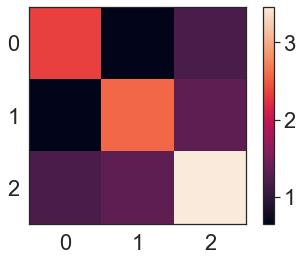

In [65]:
f = plt.imshow(model_learned_covar.detach())
plt.colorbar(f)

In [66]:
model_learned_corr = model_learned_covar / \
    (model_learned_covar.diag().unsqueeze(-1) * model_learned_covar.diag().unsqueeze(-2))**0.5

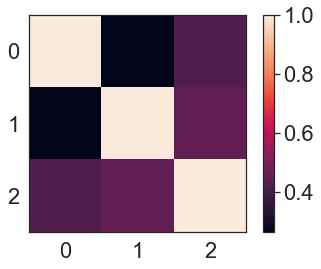

In [67]:
f = plt.imshow(model_learned_corr.detach())
plt.colorbar(f)

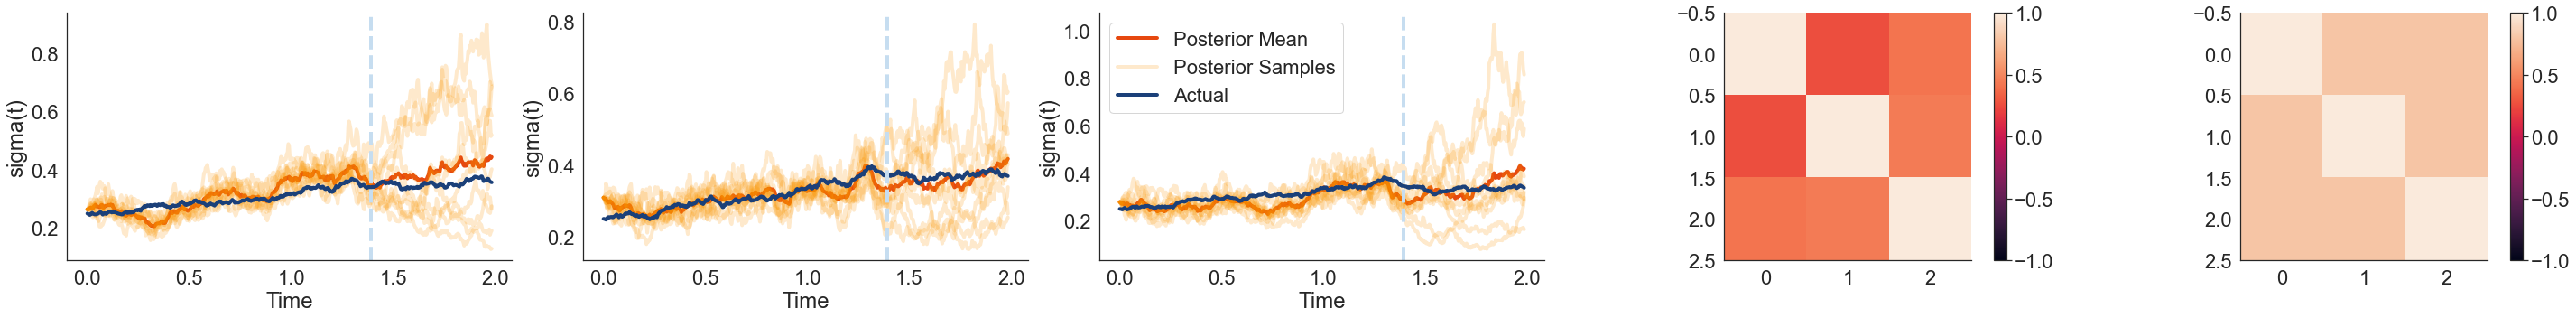

In [74]:
fig, ax = plt.subplots(1, 5, figsize = (40, 5))
plt.subplots_adjust(wspace=0.25)
# ax = ax.reshape(-1)

for i in range(n_task):

    ax[i].plot(time, pred_scale[:, i], label = "Posterior Mean", color = palette[-2])
    ax[i].plot(time, pred_sample_scale[0, :, i], color = palette[-1], alpha = 0.2, label = "Posterior Samples")
    ax[i].plot(time, pred_sample_scale[1:, :, i].t(), color = palette[-1], alpha = 0.2)
    # ax2 = ax[i].twinx()
    # ax2.plot(time, V[:, i], label = "Actual", color='orangered')
    ax[i].plot(time, V[:, i], label = "Actual", color = palette[0])

    ax[i].set_ylabel("sigma(t)")
    ax[i].set_xlabel("Time")
    ax[i].axvline(time[n_train], color = palette[1], linestyle="--")
    # fig.legend()
    sns.despine()
ax[i].legend()
    
f = ax[3].imshow(model_learned_corr.detach(), vmin = -1.0)
fig.colorbar(f, ax = ax[3])

f = ax[4].imshow(covar[n_task:,n_task:], vmin = -1.0)
fig.colorbar(f, ax = ax[4])

plt.tight_layout()

plt.savefig("joint_sabr_simulated.pdf", bbox_inches = "tight")

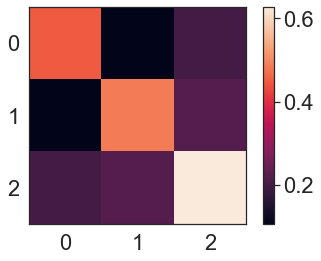

In [69]:
f = plt.imshow((model.variational_task_covar_root @ model.variational_task_covar_root.t()).detach())
plt.colorbar(f)

In [53]:
model.variational_covar_root

Parameter containing:
tensor([[ 1.3871e-02, -3.0392e-09, -6.6067e-10,  ..., -7.5499e-11,
         -4.9785e-11, -2.5267e-11],
        [ 0.0000e+00,  1.1932e-02, -1.8497e-01,  ..., -3.0371e-07,
         -2.0032e-07, -1.0166e-07],
        [ 0.0000e+00,  2.7314e-02,  3.3137e-02,  ..., -5.4754e-07,
         -3.6116e-07, -1.8326e-07],
        ...,
        [ 0.0000e+00,  4.4765e-03,  4.9854e-04,  ...,  3.2472e-02,
         -6.6244e-03, -2.9040e-03],
        [ 0.0000e+00,  4.4577e-03,  4.9721e-04,  ...,  2.9160e-02,
          6.3182e-02, -3.2214e-03],
        [ 0.0000e+00,  4.4255e-03,  4.9881e-04,  ...,  8.0675e-02,
          6.0543e-02,  2.1508e-02]], requires_grad=True)

In [54]:
s = (model.variational_task_covar_root @ model.variational_task_covar_root.t())

In [55]:
-torch.solve(s, model_learned_covar)[0].matmul(model_learned_covar.inverse())

/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  """Entry point for launching an IPython kernel.


tensor([[-0.1044,  0.0091,  0.0351],
        [ 0.0091, -0.0982,  0.0378],
        [ 0.0351,  0.0378, -0.0812]], grad_fn=<NegBackward>)

In [61]:
model_learned_covar += 2. * s

In [57]:
s

tensor([[0.4486, 0.1053, 0.1984],
        [0.1053, 0.4831, 0.2216],
        [0.1984, 0.2216, 0.6274]], grad_fn=<MmBackward>)

In [62]:
model_learned_covar

tensor([[2.7941, 0.7478, 1.3954],
        [0.7478, 3.0427, 1.5622],
        [1.3954, 1.5622, 4.0867]], grad_fn=<AddBackward0>)